##  Conversion rate

Target:

1. Predict conversion rate
2. Come up with recommendations for the product team and the marketing team to improve conversion rate

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import pandas as pd
import seaborn as sns
import datetime
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [34]:
from tool import *

In [35]:
data = pd.read_csv('./conversion_project.csv')

In [36]:
print(data.shape)

(316200, 6)


In [37]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


- country : user country based on the IP address
- age : user age. Self-reported at sign-in step
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source
1. Ads: came to the site by clicking on an advertisement
2. Seo: came to the site by clicking on search results
3. Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

In [38]:
pd.DataFrame({"Data type":data.dtypes})

,Data type
country,object
age,int64
new_user,int64
source,object
total_pages_visited,int64
converted,int64


In [39]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [40]:
pd.DataFrame({"Missing values (%)": data.isnull().sum()/len(data.index)*100})

,Missing values (%)
country,0.0
age,0.0
new_user,0.0
source,0.0
total_pages_visited,0.0
converted,0.0


In [41]:
data[data['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


A bit weird but acceptable

### Exploratory Analysis

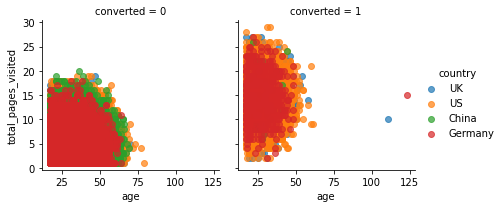

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.FacetGrid(data, col="converted", hue="country")
g.map(plt.scatter, "age", "total_pages_visited", alpha=.7)
g.add_legend();

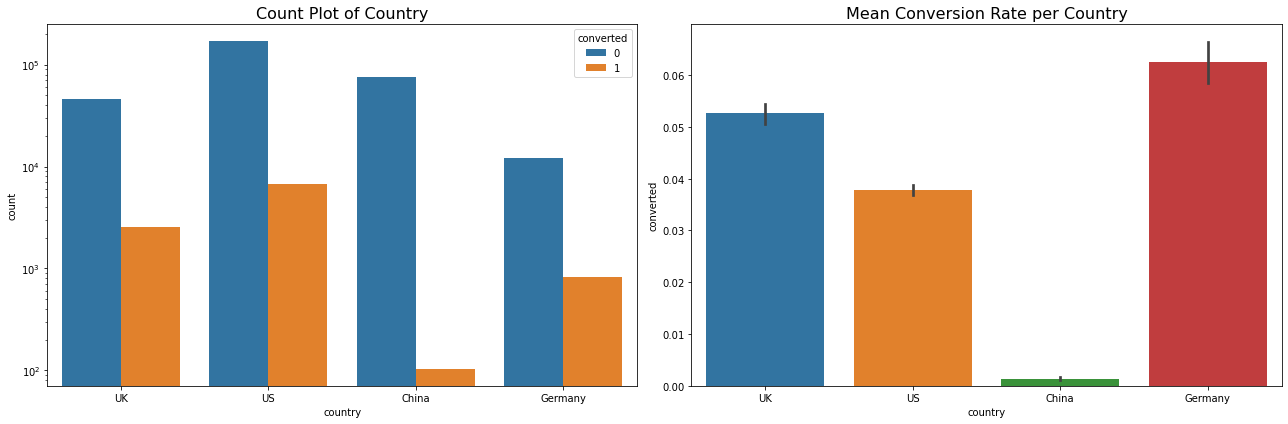

In [43]:
# Visualisation of different countries
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

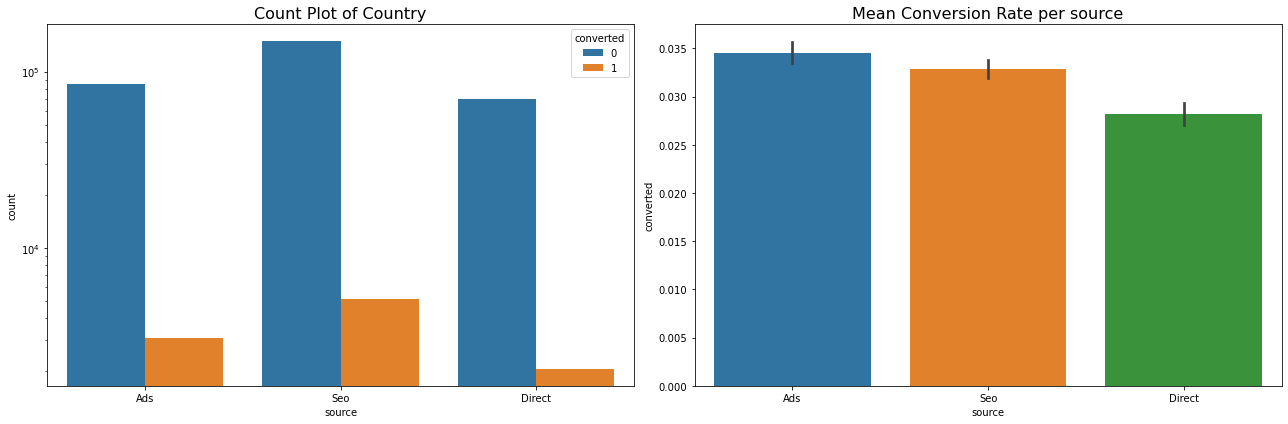

In [44]:
# Visualisation of different countries
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per source', fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\ultraviolet\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ultraviolet\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


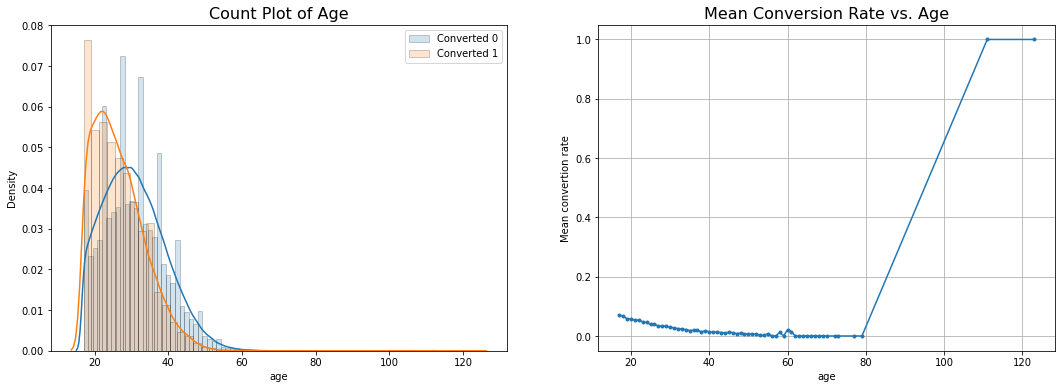

In [45]:
# Visualisation of different sources
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

C:\Users\ultraviolet\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ultraviolet\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


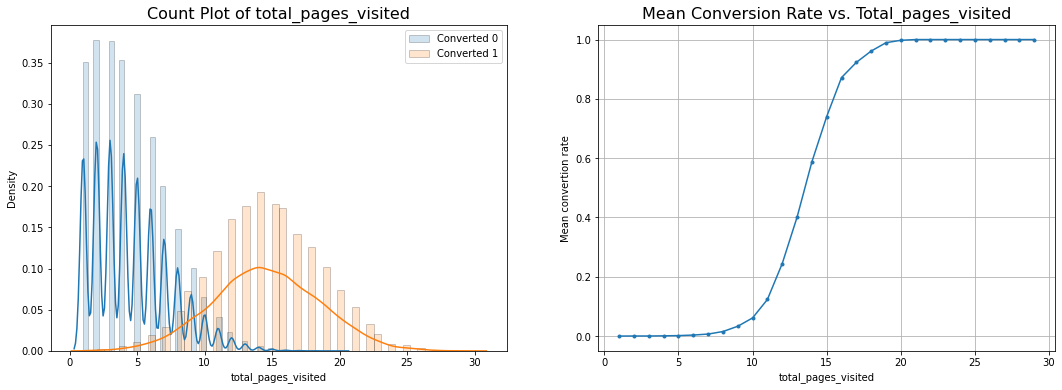

In [46]:
# Visualisation of different sources
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of total_pages_visited', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

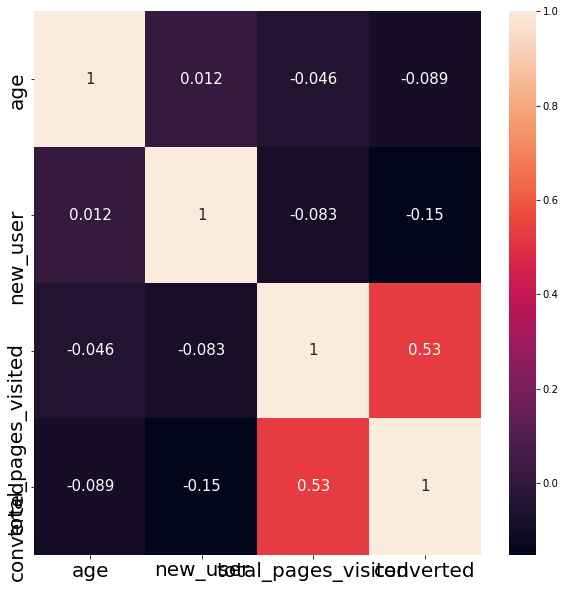

In [63]:
correlation=data.corr()
# Plot correlation
plt.figure(figsize=(10,10))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True, annot_kws={'size':15})
# Axis ticks size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

relatively positive correlation with total_pages_visited

In [48]:
df = data
df=pd.get_dummies(df, columns=['country', 'source'], drop_first=True)

In [49]:
df

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0,0,1,0,0
316196,27,1,6,0,0,0,1,1,0
316197,25,0,4,0,0,0,0,0,0
316198,22,0,4,0,0,0,1,0,1


### Modelling

In [50]:
y=df["converted"]
X=df.drop(labels= ["converted"],axis=1)

In [51]:
X.head()

,age,new_user,total_pages_visited,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,1,0,0,0
1,23,1,5,0,0,1,0,1
2,28,1,4,0,0,1,0,1
3,39,1,5,0,0,0,0,1
4,30,1,6,0,0,1,0,1


In [52]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=18)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
# Logistic Regression
log= LogisticRegression(max_iter=120000,class_weight="balanced")
log.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=120000)

In [54]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(log.coef_))], axis = 1)
coefficients

,0,0
0,age,-0.071811
1,new_user,-1.685031
2,total_pages_visited,0.761572
3,country_Germany,3.907605
4,country_UK,3.644324
5,country_US,3.317342
6,source_Direct,-0.150030
7,source_Seo,0.028931


In [55]:
y_pred= log.predict(X_test)

# Summary of the prediction
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Accuracy
print("Accuracy of the model is: ", accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     76524
           1       0.35      0.94      0.51      2526

    accuracy                           0.94     79050
   macro avg       0.68      0.94      0.74     79050
weighted avg       0.98      0.94      0.96     79050

[[72224  4300]
 [  163  2363]]
Accuracy of the model is:  0.9435420619860847


In [56]:
from sklearn.metrics import precision_recall_curve
y_true = y_test
y_scores = log.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

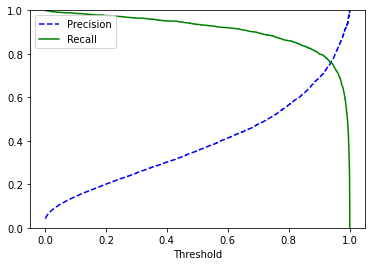

In [57]:

plot_precision_recall_vs_threshold(precision,recall,thresholds)
plt.show()

## ROC and AUC

In [58]:
fpr_train, tpr_train, auc_score_train=calculate_roc_auc(log, X_train, y_train)
fpr_test, tpr_test, auc_score_test=calculate_roc_auc(log, X_test, y_test)

In [59]:
s_train = log.predict_proba(X_train)[:, 1]
s_test = log.predict_proba(X_test)[:, 1]
va=calculate_roc(y_train, s_train, y_test, s_test)

In [60]:
def plot_roc_auc2(train_fpr,train_tpr,test_fpr,test_tpr):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(auc_score_train))
    ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(auc_score_test))
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.legend(fontsize=12)
    plt.show()    

In [61]:
train_fpr=va['train']['fpr']
train_tpr=va['train']['tpr']
test_fpr=va['test']['fpr']
test_tpr=va['test']['tpr']


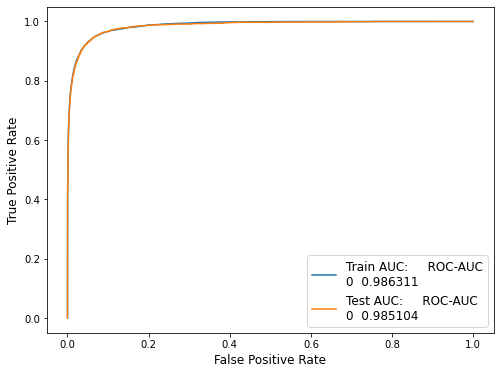

In [62]:
plot_roc_auc2(train_fpr,train_tpr,test_fpr,test_tpr)

## Conclusion

Conversion in Germany, USA and UK is good